In [1]:

import sys
sys.path.append('/Users/charleshiggins/Personal/CharlesPhD/CodeRepo/xai_intervention/RL-LRP/')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from contextlib import contextmanager
from experiments import reverse_layer, diff_softmax

/Users/charleshiggins/miniconda3/envs/minatar/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/charleshiggins/miniconda3/envs/minatar/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/charleshiggins/miniconda3/envs/minatar/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <E459C462-F863-3A5A-AC9F-FD77B14BE845> /Users/charleshiggins/miniconda3/envs/minatar/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
# Define a simple neural network with explicit activation functions
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(8000, 50) #make sure to switch to 320 for maxpooling
        self.fc2 = nn.Linear(50, 10)
        
    # Simple forward pass without maxpooling for the PoC 
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        # print(f"shape before")
        # print(x.shape)
        x = x.view(-1, 20*20*20)
        # print(f"shape after: {x.shape}")
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        # return x
        return F.log_softmax(x, dim=1)
            
    # def forward(self, x):
    #     x = F.max_pool2d(F.relu(self.conv1(x)), 2)
    #     x = F.max_pool2d(F.relu(self.conv2(x)), 2)
    #     print(f"shape before")
    #     print(x.shape)
    #     x = x.view(-1, 320)
    #     print(f"shape after: {x.shape}")
    #     x = F.relu(self.fc1(x))
    #     x = self.fc2(x)
    #     return F.log_softmax(x, dim=1)

Train Epoch: [0/60000 (0%)]	Loss: 0.940580


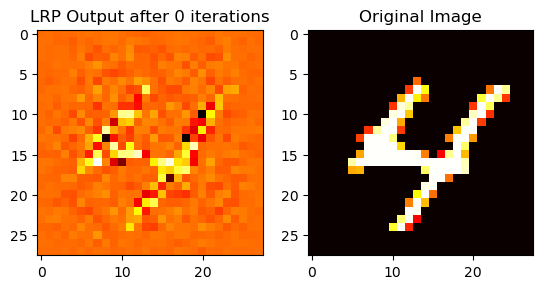

Train Epoch: [640/60000 (1%)]	Loss: 0.014531
Train Epoch: [1280/60000 (2%)]	Loss: 0.014844
Train Epoch: [1920/60000 (3%)]	Loss: 0.012283
Train Epoch: [2560/60000 (4%)]	Loss: 0.011853
Train Epoch: [3200/60000 (5%)]	Loss: 0.011051


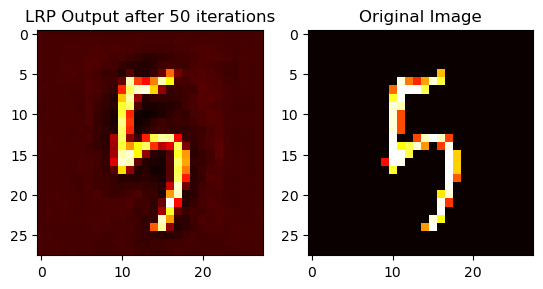

Train Epoch: [3840/60000 (6%)]	Loss: 0.010869
Train Epoch: [4480/60000 (7%)]	Loss: 0.010674
Train Epoch: [5120/60000 (9%)]	Loss: 0.009695
Train Epoch: [5760/60000 (10%)]	Loss: 0.009688
Train Epoch: [6400/60000 (11%)]	Loss: 0.009928


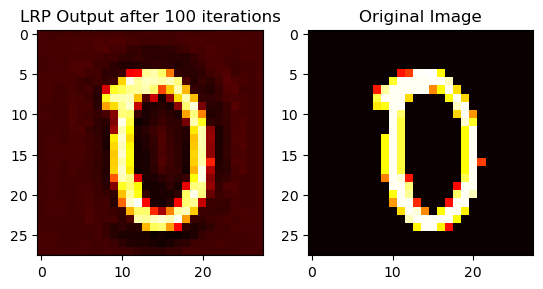

KeyboardInterrupt: 

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import wandb
from experiments import SimpleRNet, apply_threshold, WrapperNet
from experiments import CosineDistanceLoss, ManualCNN
from matplotlib import pyplot as plt
import numpy as np
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

# Initialize the network and optimizer for the underlying network


data, target = next(iter(test_loader))
# model = DiffLrpWrapper(SimpleRNet())
model = WrapperNet(SimpleNet())
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# now wrap the network in the LRP class
# wrapped_model = DiffLrpWrapper(model)
criterion = CosineDistanceLoss()

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


# over_train_data, over_train_target = data[:1,:,:,:], target[:1]  # Get a single image and target
# # expand so we repeat the same input to a batch size of 64
# over_train_data, over_train_target = over_train_data.expand(64, 1, 28, 28), over_train_target.expand(64)

model.train()
for x in range(1000):
    data, target = next(iter(test_loader))
    data, target = data.to(device), target.to(device)
    target_map = apply_threshold(data, threshold=0.99)
    optimizer.zero_grad()
    # print(target.unsqueeze(1))
    output = model(data)
    # print(output.shape, target_map.shape) 
    loss = criterion(output, target_map)
    loss.backward()
    optimizer.step()
    
    if x % 10 == 0:
        print(f'Train Epoch: [{x * len(data)}/{len(train_loader.dataset)} ({100. * x / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
    if x % 50 == 0:
        # Plotting
        num = np.random.randint(0, 64)
        fig, axes = plt.subplots(1, 2)
        axes[0].imshow(output[num][0].detach().numpy(), cmap='hot')
        axes[0].set_title(f'LRP Output after {x} iterations')
        axes[1].imshow(target_map[num][0], cmap='hot')
        axes[1].set_title('Original Image')
        plt.show()
    
